### Initialize data and import libraries

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import io
import requests
import math
import statistics

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


from scipy import optimize
from datetime import timedelta, date, datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.svm import SVR

plt.style.use('seaborn-whitegrid')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

confirmed_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
#recovered_url = "https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"

url = confirmed_url
s = requests.get(url).content
cases = pd.read_csv(io.StringIO(s.decode('utf-8')))

url = deaths_url
s = requests.get(url).content
deaths = pd.read_csv(io.StringIO(s.decode('utf-8')))

#url = recovered_url
#s = requests.get(url).content
#recovered = pd.read_csv(io.StringIO(s.decode('utf-8'))).iloc[:,0:65]

cases['Country/Region'] = cases['Country/Region'].replace('Iran (Islamic Republic of)', 'Iran')
cases['Country/Region'] = cases['Country/Region'].replace('Taiwan*', 'Taiwan')
cases['Country/Region'] = cases['Country/Region'].replace('Criuse Ship', 'Diamond Princess')
cases['Country/Region'] = cases['Country/Region'].replace('Korea, South', 'South Korea')

deaths['Country/Region'] = deaths['Country/Region'].replace('Iran (Islamic Republic of)', 'Iran')
deaths['Country/Region'] = deaths['Country/Region'].replace('Taiwan*', 'Taiwan')
deaths['Country/Region'] = deaths['Country/Region'].replace('Criuse Ship', 'Diamond Princess')
deaths['Country/Region'] = deaths['Country/Region'].replace('Korea, South', 'South Korea')

#recovered['Country/Region'] = recovered['Country/Region'].replace('Iran (Islamic Republic of)', 'Iran')
#recovered['Country/Region'] = recovered['Country/Region'].replace('Taiwan*', 'Taiwan')
#recovered['Country/Region'] = recovered['Country/Region'].replace('Criuse Ship', 'Diamond Princess')
#recovered['Country/Region'] = recovered['Country/Region'].replace('Korea, South', 'South Korea')

countries = cases.iloc[:,1].unique()
countries.sort()

demo = pd.read_csv("/kaggle/input/world-population-demographics-by-age-2019/world_demographics.csv")

demo["Country or Area"] = demo["Country or Area"].replace("Viet Nam", "Vietnam")
demo["Country or Area"] = demo["Country or Area"].replace("United States of America", "US")
demo["Country or Area"] = demo["Country or Area"].replace("United Kingdom of Great Britain and Northern Ireland", "United Kingdom")
demo["Country or Area"] = demo["Country or Area"].replace("Republic of Korea", "South Korea")
demo["Country or Area"] = demo["Country or Area"].replace("Venezuela (Bolivarian Republic of)", "Venezuela")
demo["Country or Area"] = demo["Country or Area"].replace('Iran (Islamic Republic of)', 'Iran')

duc = demo["Country or Area"].unique()
duc.sort()

deathrate_age = list(range(0,120))
deathrate_age[0:30] = [0]*30
deathrate_age[30:40] = [0.0012]*10
deathrate_age[40:50] = [0.0009]*10
deathrate_age[50:60] = [0.0039]*10
deathrate_age[60:70] = [0.0142]*10
deathrate_age[70:80] = [0.0474]*10
deathrate_age[80:120] = [0.083]*40

print("Latest date: ", cases.columns.values[-1])

/kaggle/input/world-population-demographics-by-age-2019/world_demographics.csv
Latest date:  4/7/20


Calculate Vulnerability

In [26]:
def calcVF(country1, country2):
    ma = np.where(demo["Country or Area"] == country1)[0]
    demo_c1 = demo.iloc[ma,:]
    ma = np.where(demo["Country or Area"] == country2)[0]
    demo_c2 = demo.iloc[ma,:]
    ll = list(range(0,120))
    ll = [str(i) for i in ll]
    ma = np.where(np.isin(demo_c1["Age"], np.array(ll)))[0]
    demo_c1 = demo_c1.iloc[ma,:]
    ma = np.where(np.isin(demo_c2["Age"], np.array(ll)))[0]
    demo_c2 = demo_c2.iloc[ma,:]
    vulnerable_c1 = [a * b for a, b in zip(demo_c1["Value"], deathrate_age)]
    vulnerable_c2 = [a * b for a, b in zip(demo_c2["Value"], deathrate_age)]
    v_c1 = sum(vulnerable_c1)/sum(demo_c1["Value"])
    v_c2 = sum(vulnerable_c2)/sum(demo_c2["Value"])
    exp_diff = v_c1/v_c2
    return(exp_diff)

Calculate Growth Rate

In [27]:
def calculateGR(country1, d_shift):
    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]

    sds2 = d_count_1[d_cases]
    s1 = list(sds2)+[0]
    s2 = [0]+list(sds2)
    gr = np.array(s1)/np.array(s2)
    gr = pd.Series(np.array(gr[1:(len(gr)-1)]))

    new_deaths = np.array(s1)-np.array(s2)
    
    mean_gr = sum(list(gr))/len(list(gr))
    mean_double = math.log(2)/math.log(mean_gr)
    gr.index = d_count_1[d_cases][1:len(d_cases)].index
    doublings = np.log(2)/np.log(gr)

    tran = [(datetime.strptime(i, "%m/%d/%y") - timedelta(days=d_shift)).strftime("%-m/%-d/%y") for i in gr.index]
    gr.index = tran
    return(gr)

Plot Growth Rate

In [28]:
def plotGR(country1, gr, doublings):
    
    popt, params_covariance = optimize.curve_fit(funcLin, range(0,4), gr[-4:], p0=[2, 2])
    linf = funcLin(np.array(range(0,4)), *popt)

    
    plt.figure(figsize=(10,6))
    fig, ax = plt.subplots(constrained_layout=True)
    ax.grid(False)

    plt.ylim(0.95, 1.8)
    res1, = plt.plot(gr, 'ro-', label="Growth Rate ("+country1+")")
    plt.ylabel("growth rate")

    resx, = plt.plot(range(len(gr)-len(linf),len(gr)), linf, 'go-', label="Predicted Rate ("+country1+")")
    
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='y', colors='red')

    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    plt.xticks(rotation=60)
    ax2 = ax.twinx()
    ax2.yaxis.label.set_color('blue')
    ax2.tick_params(axis='y', colors='blue')

    res2, = ax2.plot(doublings, 'b^-', label="Doubling Time (days)")
    plt.ylim(top=8)
    plt.ylabel("doubling time (days)")
    plt.legend(handles=[res1, res2])
    plt.show()

PredictCases

In [29]:
def predictCases(country1, country2, d_shift, p=False):
    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]
    sds2 = d_count_1[d_cases]
    
    ma = np.where(cases["Country/Region"] == country2)[0]
    c_count_2 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_2 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c2 = d_count_2 / c_count_2

    predicted_deaths = list(range(0,d_shift+1))
    predicted_deaths[0] = sds2[-1]

    for i in range(1,d_shift+1):
        predicted_deaths[i] = predicted_deaths[i-1]*gr[-1]

    combined_deaths = list(sds2) + list(predicted_deaths[1:len(predicted_deaths)])
    predicted_cases = np.array(combined_deaths) / (exp_diff*dr_c2[-1])
    shift_cases = predicted_cases[-(len(d_cases)+1):-1]
    
    if p:
        plt.figure(figsize=(10,6))
        fig, ax = plt.subplots(constrained_layout=True)
        ax.grid(False)

        res1, = plt.plot(c_count_1[d_cases], 'bo-', label="Reported Cases ("+country1+")")
        res2, = plt.plot(shift_cases, 'ro-', label="Adjusted Cases ("+country1+")")
        plt.xticks(rotation=60)
        ax.axvline(x=len(d_cases)-6)

        plt.ylabel("cases")
        plt.xticks(rotation=90)
        plt.legend(handles=[res1, res2])
        plt.show()

    return(shift_cases)

Plot death rate

In [30]:
def plotDR(country1, country2):
    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1

    ma = np.where(cases["Country/Region"] == country2)[0]
    c_count_2 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_2 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c2 = d_count_2 / c_count_2

    sig_cases = np.where(c_count_1 > 100)[0]
    ax1 = plt.subplot(1,1,1)
    res1, = plt.plot(range(0,len(sig_cases)), c_count_1[sig_cases], 'ro-', linewidth=3, label="reported cases")

    ax1.grid(False)
    plt.xticks(rotation=60)
    ax2 = ax1.twinx()
    res3, = ax2.plot(d_count_1[sig_cases], 'gs-', linewidth=3, label="deaths")

    for label in ax1.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)

    plt.title(country1)
    ax1.set_ylabel('cases', color="black")
    color = 'green'
    ax2.set_ylabel('deaths', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(handles=[res1, res3])

    plt.figure(figsize=(10,6))
    plt.rc('ytick', labelsize=23) 
    plt.rc('xtick', labelsize=13)

    res1, = plt.plot(dr_c1[sig_cases]*100, 'b.-', label="Death rate ("+country1+")")
    res2, = plt.plot(dr_c2[sig_cases]*100, 'r.-', label="Death rate ("+country2+")")
    plt.xticks(rotation=60)
    plt.ylabel("death rate")

    plt.legend(handles=[res1, res2])
    plt.show()


In [31]:
def getMGR(country, shift):
    gr = calculateGR(country, shift)
    mgr = mean_gr = sum(list(gr))/len(list(gr))
    return(mgr)

In [32]:
def extrapolateDeaths(country, fitrate, intervention, timescale=50, shift=0, pastDays=23):
    
    ma = np.where(cases["Country/Region"] == country)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]
    sds2 = d_count_1[d_cases]
    
    gr = calculateGR(country, 23)
    predicted_deaths = list(range(0,timescale))
    predicted_deaths[0] = sds2[-(1+shift)]
    
    for i in range(1,timescale):
        if i < 23-pastDays:
            predicted_deaths[i] = predicted_deaths[i-1]*statistics.median(gr[-7:])
        else:
            predicted_deaths[i] = predicted_deaths[i-1]*fitrate[i+14-pastDays]
    
    dd =sds2.index
    datelist = pd.date_range(pd.to_datetime(dd[len(dd)-1], format='%m/%d/%y', errors='ignore'), periods=timescale).tolist()
    str_date = [d.strftime('%m/%d/%y') for d in datelist]
    
    return(pd.DataFrame(data=predicted_deaths, index=str_date))

In [33]:
def getallMGR():
    countries = cases.iloc[:,1].unique()
    countries.sort()

    gr_list = list()
    country_name = list()

    for country in countries:
        ma = np.where(cases['Country/Region'] == country)[0]
        d_count = deaths.iloc[ma, 4:].sum(axis=0)

        if np.max(d_count) > 50:
            mgr = getMGR(country, d_shift)
            gr_list.append(mgr)
            country_name.append(country)

    df = pd.DataFrame(data=gr_list, index=country_name)
    return(df)

In [34]:
def findDecayShift(growthrates, decay_spline):
    decay_shift = 0
    ff = fitLinear(growthrates[-4:])
    ff = statistics.median(growthrates[-5:])
    while float(ff) < float(list(decay_spline)[decay_shift]):
        decay_shift = decay_shift +1
        if decay_shift-1 > len(decay_spline):
            break
    return(decay_shift)

In [35]:
 def funcLin(x, a, b):
        return((a * x) + b)

In [36]:
def fitLinear(x):
    popt, params_covariance = optimize.curve_fit(funcLin, range(0,4), x[-4:], p0=[2, 2])
    return(funcLin(np.array(range(3,4)), *popt))

In [37]:
def printStat(country1):
    print(country1)
    country2 = "South Korea"

    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)

    print("Current Confirmed Cases:", c_count_1[-1])
    print("Current Confirmed Deaths:", d_count_1[-1])
    ggr = calculateGR(country1, 0)

    ma = np.where(cases["Country/Region"] == country1)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    cde = d_count_1[-1]
    print(c_count_1[-6:])

    print("Current Confirmed Cases:", c_count_1[-1])
    print("Current Confirmed Deaths:", d_count_1[-1])

    ma = np.where(cases["Country/Region"] == country2)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)

    drr = d_count_1[-1]/c_count_1[-1]

    mean_days_death = 18
    asym_days = 5

    d_shift = mean_days_death + asym_days

    exp_diff = calcVF(country1, country2)
    print("Vunerablility Factor: ", str(round(exp_diff, 4)))

    exp_d = extrapolateDeaths(country1, fit_rate, -findDecayShift(ggr, fit_rate), timescale=80, pastDays=70)

    print("Total Deaths: ", str(int(exp_d.iloc[-1,0])))

    num = exp_d.iloc[d_shift]/(exp_diff*drr)
    print("Current Predicted Cases: ", str(int(num)))

    num = exp_d.iloc[-1]/(exp_diff*drr)
    print("Total Predicted Cases: ", str(int(num)))

    gr = calculateGR(country1, d_shift)
    print("Growth Rate: ", str(round(gr[-1], 5)))

    mean_gr = sum(list(gr))/len(list(gr))
    mean_double = math.log(2)/math.log(mean_gr)
    doublings = np.log(2)/np.log(gr)
    print("Days per Doubling: ", str(round(doublings[-1], 5)))

    print("------------------------------------")

In [38]:
def plotCaseCountry(country, ax1):
    ma = np.where(cases['Country/Region'] == country)[0]
    c_count = cases.iloc[ma, 4:].sum(axis=0)
    d_count = deaths.iloc[ma, 4:].sum(axis=0)
    
    sig_cases = np.where(c_count > 30)[0]
    
    res1, = plt.plot(c_count[sig_cases], 'ro-', linewidth=3, label="reported cases")
    plt.xticks(rotation=90)
    ax2 = ax1.twinx()
    res3, = ax2.plot(d_count[sig_cases], 'gs-', linewidth=3, label="deaths")

    plt.title(country)
    ax1.set_ylabel('cases', color="black")
    color = 'green'
    ax2.set_ylabel('deaths', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(handles=[res1, res3])

In [39]:
def funcUp(x, a, b):
    return a * np.exp(-b * x)+1

In [40]:
def fitUp(x, timerange):
    popt, params_covariance = optimize.curve_fit(funcUp, range(0, len(x)), x, p0=[2, 2])
    print(popt)
    return(funcUp(np.array(range(0,timerange)), *popt))

[0.26924086 0.10517263]


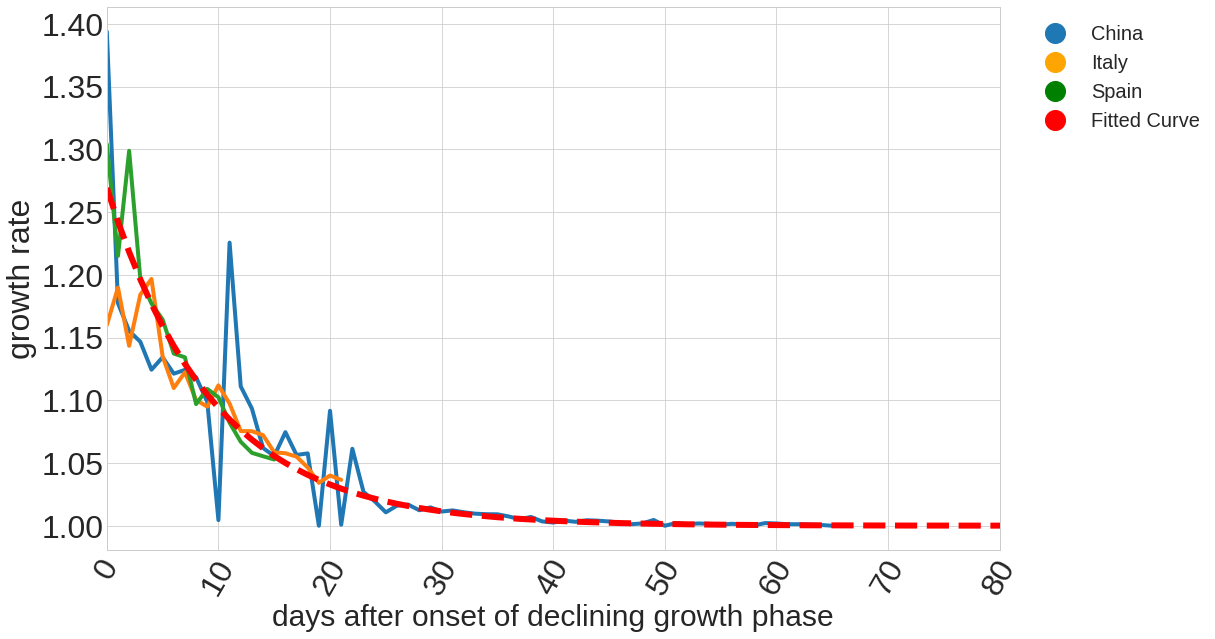

In [41]:
country1 = "Italy"
country2 = "China"
country3 = "Iran"
country4 = "Spain"

gr1 = list(calculateGR(country1, 23))
gr2 = list(calculateGR(country2, 23))
gr3 = list(calculateGR(country3, 23))
gr4 = list(calculateGR(country4, 23))

g1 = gr1[19:len(gr1)]
g2 = gr2[10:len(gr2)]
g3 = gr3[14:len(gr3)]
g4 = gr4[14:len(gr4)]

plt.figure(figsize=(16,10))
plt.plot(g2, label="Death rate ("+country2+")", linewidth=4)
plt.plot(g1, label="Death rate ("+country1+")", linewidth=4)
#plt.plot(g3, label="Death rate ("+country3+")", linewidth=4)
plt.plot(g4, label="Death rate ("+country4+")", linewidth=4)

plt.xticks(rotation=60, fontsize=32)
plt.yticks(fontsize=32)

def func(x, a, b):
    return a * np.exp(-b * x)+1

#x = list(range(0,len(g1)))+list(range(0, len(g2)))
#y = list(g1+g2)
x = list(range(0,len(g1)))+list(range(0, len(g2)))+list(range(0, len(g4)))
y = list(g1+g2+g4)

popt, params_covariance = optimize.curve_fit(func, x[3:len(x)], y[3:len(y)], p0=[2, 2])

xrange = 200
fit_rate = func(np.array(list(range(0, xrange))), *popt)

print(popt)

plt.plot(np.array(list(range(0,xrange))), fit_rate, 'r--', label="Fitted Curve", linewidth=6)

plt.ylabel("growth rate", fontsize=32)
plt.xlabel("days after onset of declining growth phase", fontsize=30)
plt.xlim(0,80)

legend_elements = [Line2D([0], [0], marker='o', linewidth=0, label='China', markersize=20),
                   Line2D([0], [0], marker='o', linewidth=0, color="orange", label='Italy', markersize=20),
                   Line2D([0], [0], marker='o', linewidth=0, color="g", label='Spain', markersize=20),
                   Line2D([0], [0], marker='o', linewidth=0, color="r", label='Fitted Curve', markersize=20)]
                   
plt.legend(handles=legend_elements, fontsize=20, bbox_to_anchor=(1.02, 1), loc='upper left', ncol=1)

In [42]:
def findDecayShift(growthrates, decay_spline):
    decay_shift = 0
    ff = fitLinear(growthrates[-5:])
    ff = statistics.median(growthrates[-5:])
    
    while float(ff) < float(list(decay_spline)[decay_shift]):
        decay_shift = decay_shift +1
        if decay_shift-1 > len(decay_spline):
            break
    return(decay_shift+3)

In [43]:
def extrapolateDeaths(country, fitrate, intervention, timescale=60, shift=0, pastDays=23, exprate=1.25):
    
    ma = np.where(cases["Country/Region"] == country)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]
    sds2 = d_count_1[d_cases]
    
    gr = calculateGR(country, 23)
    gr = gr[0:(len(gr)-shift)]
    
    predicted_deaths = list(range(0,timescale))
    predicted_deaths[0] = sds2[-(1+shift)]
    
    #ff = fitUp(sds2[0:(1+shift)], len(sds2)+40)
    j = 0
    for i in range(1,timescale):
        if i < 23-pastDays:
            predicted_deaths[i] = predicted_deaths[i-1]*exprate
            #predicted_deaths[i] = predicted_deaths[i-1]*statistics.median(gr[-4:])
            #predicted_deaths[i] = ff[(shift)+i]
        else:
            predicted_deaths[i] = predicted_deaths[i-1]*fitrate[j-intervention]
            j = j+1
    
    dd =sds2.index
    datelist = pd.date_range(pd.to_datetime(dd[len(dd)-1], format='%m/%d/%y', errors='ignore'), periods=timescale).tolist()
    str_date = [d.strftime('%m/%d/%y') for d in datelist]
    
    return(pd.DataFrame(data=predicted_deaths, index=str_date))

K: 18 SD: 64005.883613987324
K: 19 SD: 51209.43558265346
K: 20 SD: 40970.95405373856
K: 21 SD: 32779.215914833556
K: 22 SD: 26225.13910930571
K: 23 SD: 20142.11786009345
K: 24 SD: 14745.658266028782
K: 25 SD: 10174.96643566905
K: 26 SD: 6970.103504682007
K: 27 SD: 5740.141130564175
K: 28 SD: 6398.049689512138
K: 29 SD: 7806.4855857154525
K: 30 SD: 9382.835201250271
K: 31 SD: 10730.342837116497
K: 32 SD: 11795.046989835313
K: 33 SD: 12593.570915001555
K: 34 SD: 13164.18840373019
K: 35 SD: 13552.715227571785
K: 36 SD: 13801.202082244341
K: 37 SD: 13954.232003324423
K: 38 SD: 14031.35981785948
K: 39 SD: 14061.751818868286
K: 40 SD: 14061.751818868286
K: 41 SD: 14061.751818868286
K: 42 SD: 14061.751818868286
K: 43 SD: 14061.751818868286
K: 44 SD: 14061.751818868286
K: 45 SD: 14061.751818868286
r: 1.15 SD: 9205.831341915966
r: 1.16 SD: 8815.96229645923
r: 1.17 SD: 8407.753347624124
r: 1.18 SD: 7983.371995942609
r: 1.19 SD: 7546.624806469984
r: 1.2 SD: 7103.766164338008
r: 1.21 SD: 6664.6821

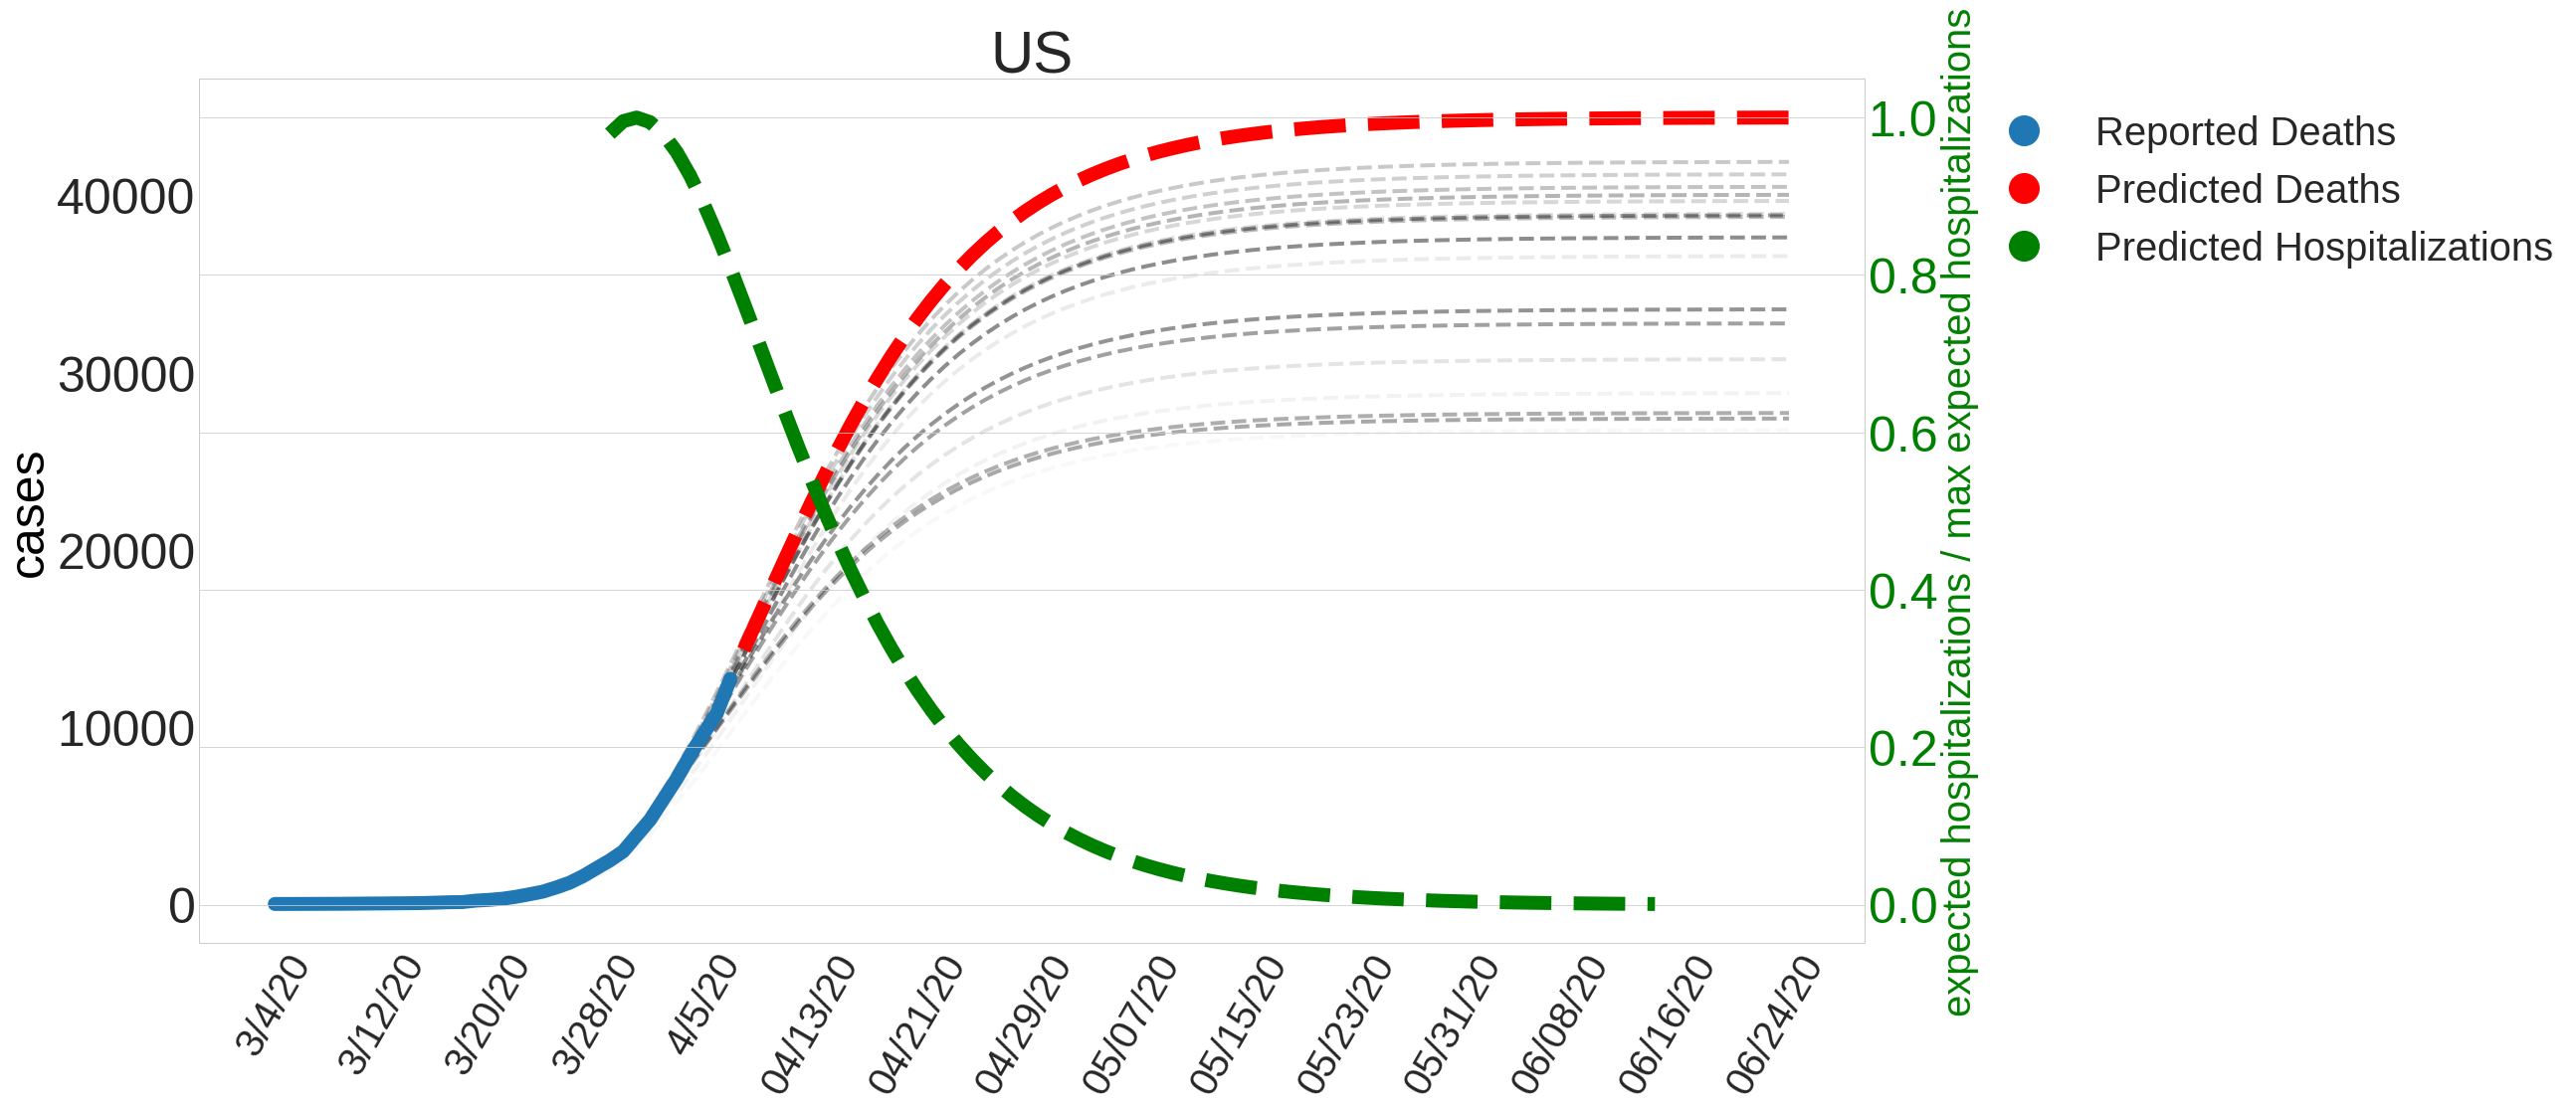

In [44]:
country = "US"
limi = 18

ma = np.where(cases["Country/Region"] == country)[0]
c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
dr_c1 = d_count_1 / c_count_1
d_cases = np.where(d_count_1 > 10)[0]
sds2 = d_count_1[d_cases]

ggr = calculateGR(country, 0)

plt.figure(figsize=(30,16))
ax1 = plt.subplot(1,1,1)

ax1.grid(False)
#plt.ylim(top=(list(exp_d.iloc[:,0])[-1]+500))

mink = 0
minsd = 100000000

for k in range(18, 46):
    expl = list()
    for i in range(0,limi):
        sts = statistics.mean(ggr[0:(len(ggr)-i)][-5:])
        decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)    
        exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=k-i)
        expl.append(exp_d.iloc[-1,0])
    print("K: "+str(k)+ " SD: "+str(statistics.stdev(expl)))
    if statistics.stdev(expl) < minsd:
        minsd = statistics.stdev(expl)
        mink = k

minr = 1.2
minsd = 1000000000
for k in [1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3]:
    expl = list()
    for i in range(1,limi):
        decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)    
        exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=mink-i, exprate=k)
        expl.append(exp_d.iloc[-1,0])
    print("r: "+str(k)+ " SD: "+str(statistics.stdev(expl)))
    if statistics.stdev(expl) < minsd:
        minsd = statistics.stdev(expl)
        minr = k        

for i in range(1,limi):
    decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)
    exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=mink-i, exprate=minr)
    ax1.plot(range(len(sds2)-i, len(sds2)-i+len(exp_d)-1), exp_d[1:len(exp_d)], 'r--', label="Predicted Deaths", linewidth=4, color="black", alpha=(limi-i)/(limi+20))

decay_position = -findDecayShift(ggr, fit_rate)
exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80, pastDays=mink)

res1, = ax1.plot(sds2, linewidth=14, label="Reported Deaths")
res3, = ax1.plot(exp_d[1:len(exp_d)], 'r--', label="Predicted Deaths", linewidth=14)

l1 = np.array(([0]+list(exp_d))) - np.array((list(exp_d)+[0]))

plt.xticks(rotation=60, fontsize=40)
plt.yticks(fontsize=50)

s1 = list(exp_d.iloc[:,0])+[0]
s2 = [0]+list(exp_d.iloc[:,0])

ax2 = ax1.twinx()
plt.yticks(fontsize=50)
dd = (np.array(s1)-np.array(s2))[1:(len(s1)-1)]
res4, = ax2.plot(range(len(sds2)-10,(len(dd)-10+len(sds2))),dd/np.max(np.array(dd)), 'g--', linewidth=14, label="Hospitalizations / max Hospitalizations")

for label in ax1.xaxis.get_ticklabels()[::1]:
    label.set_visible(False)

for label in ax1.xaxis.get_ticklabels()[::8]:
    label.set_visible(True)

plt.title(country, fontsize=60)
ax1.set_ylabel('cases', color="black", fontsize=50)
color = 'green'
ax2.set_ylabel('expected hospitalizations / max expected hospitalizations', color=color, fontsize=40)
ax2.tick_params(axis='y', labelcolor=color)

legend_elements = [Line2D([0], [0], marker='o', linewidth=0, label='Reported Deaths', markersize=30),
                   Line2D([0], [0], marker='o', linewidth=0, color="r", label='Predicted Deaths', markersize=30),
                   Line2D([0], [0], marker='o', linewidth=0, color="g", label='Predicted Hospitalizations', markersize=30)]
                   
plt.legend(handles=legend_elements, fancybox = True, fontsize=40, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

1/22/20        0
1/23/20        0
1/24/20        0
1/25/20        0
1/26/20        0
           ...  
4/3/20     11198
4/4/20     11947
4/5/20     12641
4/6/20     13341
4/7/20     14045
Length: 77, dtype: int64
4/2/20    112065
4/3/20    119199
4/4/20    126168
4/5/20    131646
4/6/20    136675
4/7/20    141942
dtype: int64
Current Confirmed Cases: 141942
Current Confirmed Deaths: 14045
Vunerablility Factor:  1.3642
Total Deaths:  20990
Current Predicted Cases:  798644
Total Predicted Cases:  827936
Growth Rate:  1.05277
Days per Doubling:  13.47894


<Figure size 720x432 with 0 Axes>

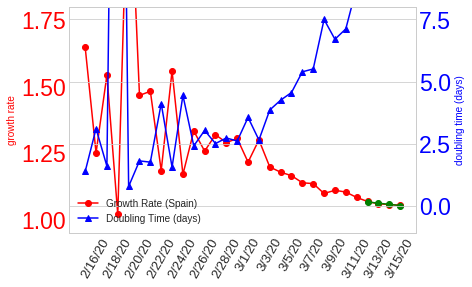

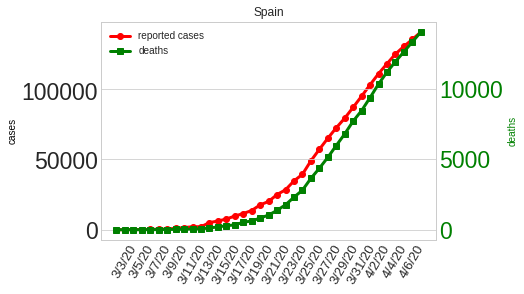

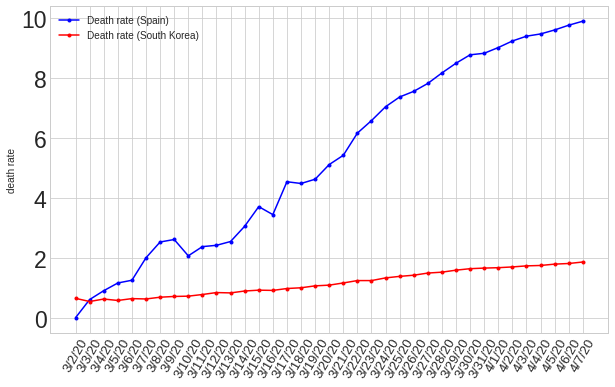

In [45]:
country1 = "Spain"
country2 = "South Korea"

ma = np.where(cases["Country/Region"] == country1)[0]
c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
print(d_count_1)
print(c_count_1[-6:])

ggr = calculateGR(country1, 0)

print("Current Confirmed Cases:", c_count_1[-1])
print("Current Confirmed Deaths:", d_count_1[-1])

ma = np.where(cases["Country/Region"] == country2)[0]
c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)

drr = d_count_1[-1]/c_count_1[-1]

mean_days_death = 18
asym_days = 5

d_shift = mean_days_death + asym_days

exp_diff = calcVF(country1, country2)
print("Vunerablility Factor: ", str(round(exp_diff, 4)))

exp_d = extrapolateDeaths(country1, fit_rate, -findDecayShift(ggr, fit_rate), timescale=80)

print("Total Deaths: ", str(int(exp_d.iloc[-1,0])))

num = exp_d.iloc[d_shift]/(exp_diff*drr)
print("Current Predicted Cases: ", str(int(num)))

num = exp_d.iloc[-1]/(exp_diff*drr)
print("Total Predicted Cases: ", str(int(num)))

gr = calculateGR(country1, d_shift)
print("Growth Rate: ", str(round(gr[-1], 5)))

mean_gr = sum(list(gr))/len(list(gr))
mean_double = math.log(2)/math.log(mean_gr)
doublings = np.log(2)/np.log(gr)
print("Days per Doubling: ", str(round(doublings[-1], 5)))

#print("Total Predicted Cases: ",shift_cases[-1])

plotGR(country1, gr, doublings)
plotDR(country1, country2)

In [56]:
def plotPred(country, ax1):
    limi = 18
    ma = np.where(cases["Country/Region"] == country)[0]
    c_count_1 = cases.iloc[ma, 4:].sum(axis=0)
    d_count_1 = deaths.iloc[ma, 4:].sum(axis=0)
    dr_c1 = d_count_1 / c_count_1
    d_cases = np.where(d_count_1 > 10)[0]
    sds2 = d_count_1[d_cases]

    ggr = calculateGR(country, 0)
    
    ax1.grid(False)
    
    mink = 0
    minsd = 100000000

    for k in range(18, 80):
        expl = list()
        for i in range(0,limi):
            sts = statistics.mean(ggr[0:(len(ggr)-i)][-5:])
            decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)    
            exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=k-i)
            expl.append(exp_d.iloc[-1,0])
        #print("K: "+str(k)+ " SD: "+str(statistics.stdev(expl)))
        if statistics.stdev(expl) < minsd:
            minsd = statistics.stdev(expl)
            mink = k

    minr = 1.2
    minsd = 1000000000
    for k in [1.15, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3]:
        expl = list()
        for i in range(1,limi):
            decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)    
            exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=mink-i, exprate=k)
            expl.append(exp_d.iloc[-1,0])
        #print("r: "+str(k)+ " SD: "+str(statistics.stdev(expl)))
        if statistics.stdev(expl) < minsd:
            minsd = statistics.stdev(expl)
            minr = k        

            
    print("K: "+str(mink)+" R: "+str(minr))
    
    for i in range(0,limi):
        decay_position = -findDecayShift(ggr[0:(len(ggr)-i)], fit_rate)
        exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80+i, shift=i, pastDays=mink-i, exprate=minr)
        ax1.plot(range(len(sds2)-i, len(sds2)-i+len(exp_d)-1), exp_d[1:len(exp_d)], 'r--', label="Predicted Deaths", linewidth=4, color="black", alpha=(limi-i)/(limi+20))

    decay_position = -findDecayShift(ggr, fit_rate)
    print(decay_position)
    exp_d = extrapolateDeaths(country, fit_rate, decay_position, timescale=80)

    res1, = ax1.plot(sds2, linewidth=14, label="Reported Deaths")
    res3, = ax1.plot(exp_d[1:len(exp_d)], 'r--', label="Predicted Deaths", linewidth=14)
    
    l1 = np.array(([0]+list(exp_d))) - np.array((list(exp_d)+[0]))

    plt.xticks(rotation=60, fontsize=40)
    plt.yticks(fontsize=50)

    s1 = list(exp_d.iloc[:,0])+[0]
    s2 = [0]+list(exp_d.iloc[:,0])

    ax2 = ax1.twinx()
    plt.yticks(fontsize=50)
    dd = (np.array(s1)-np.array(s2))[1:(len(s1)-1)]
    res4, = ax2.plot(range(len(sds2)-10,(len(dd)-10+len(sds2))),dd/np.max(np.array(dd)), 'g--', linewidth=14, label="Hospitalizations / max Hospitalizations")

    for label in ax1.xaxis.get_ticklabels()[::1]:
        label.set_visible(False)

    for label in ax1.xaxis.get_ticklabels()[::8]:
        label.set_visible(True)

    plt.title(country, fontsize=80)
    ax1.set_ylabel('deaths', color="black", fontsize=50)
    color = 'green'
    ax2.set_ylabel('expected hosp / max expected hosp', color=color, fontsize=40)
    ax2.tick_params(axis='y', labelcolor=color)


K: 39 R: 1.15
-58
K: 31 R: 1.22
-9
K: 30 R: 1.27
-10
K: 27 R: 1.26
-7
K: 33 R: 1.26
-12
K: 27 R: 1.24
-9
K: 35 R: 1.26
-18
K: 38 R: 1.21
-22


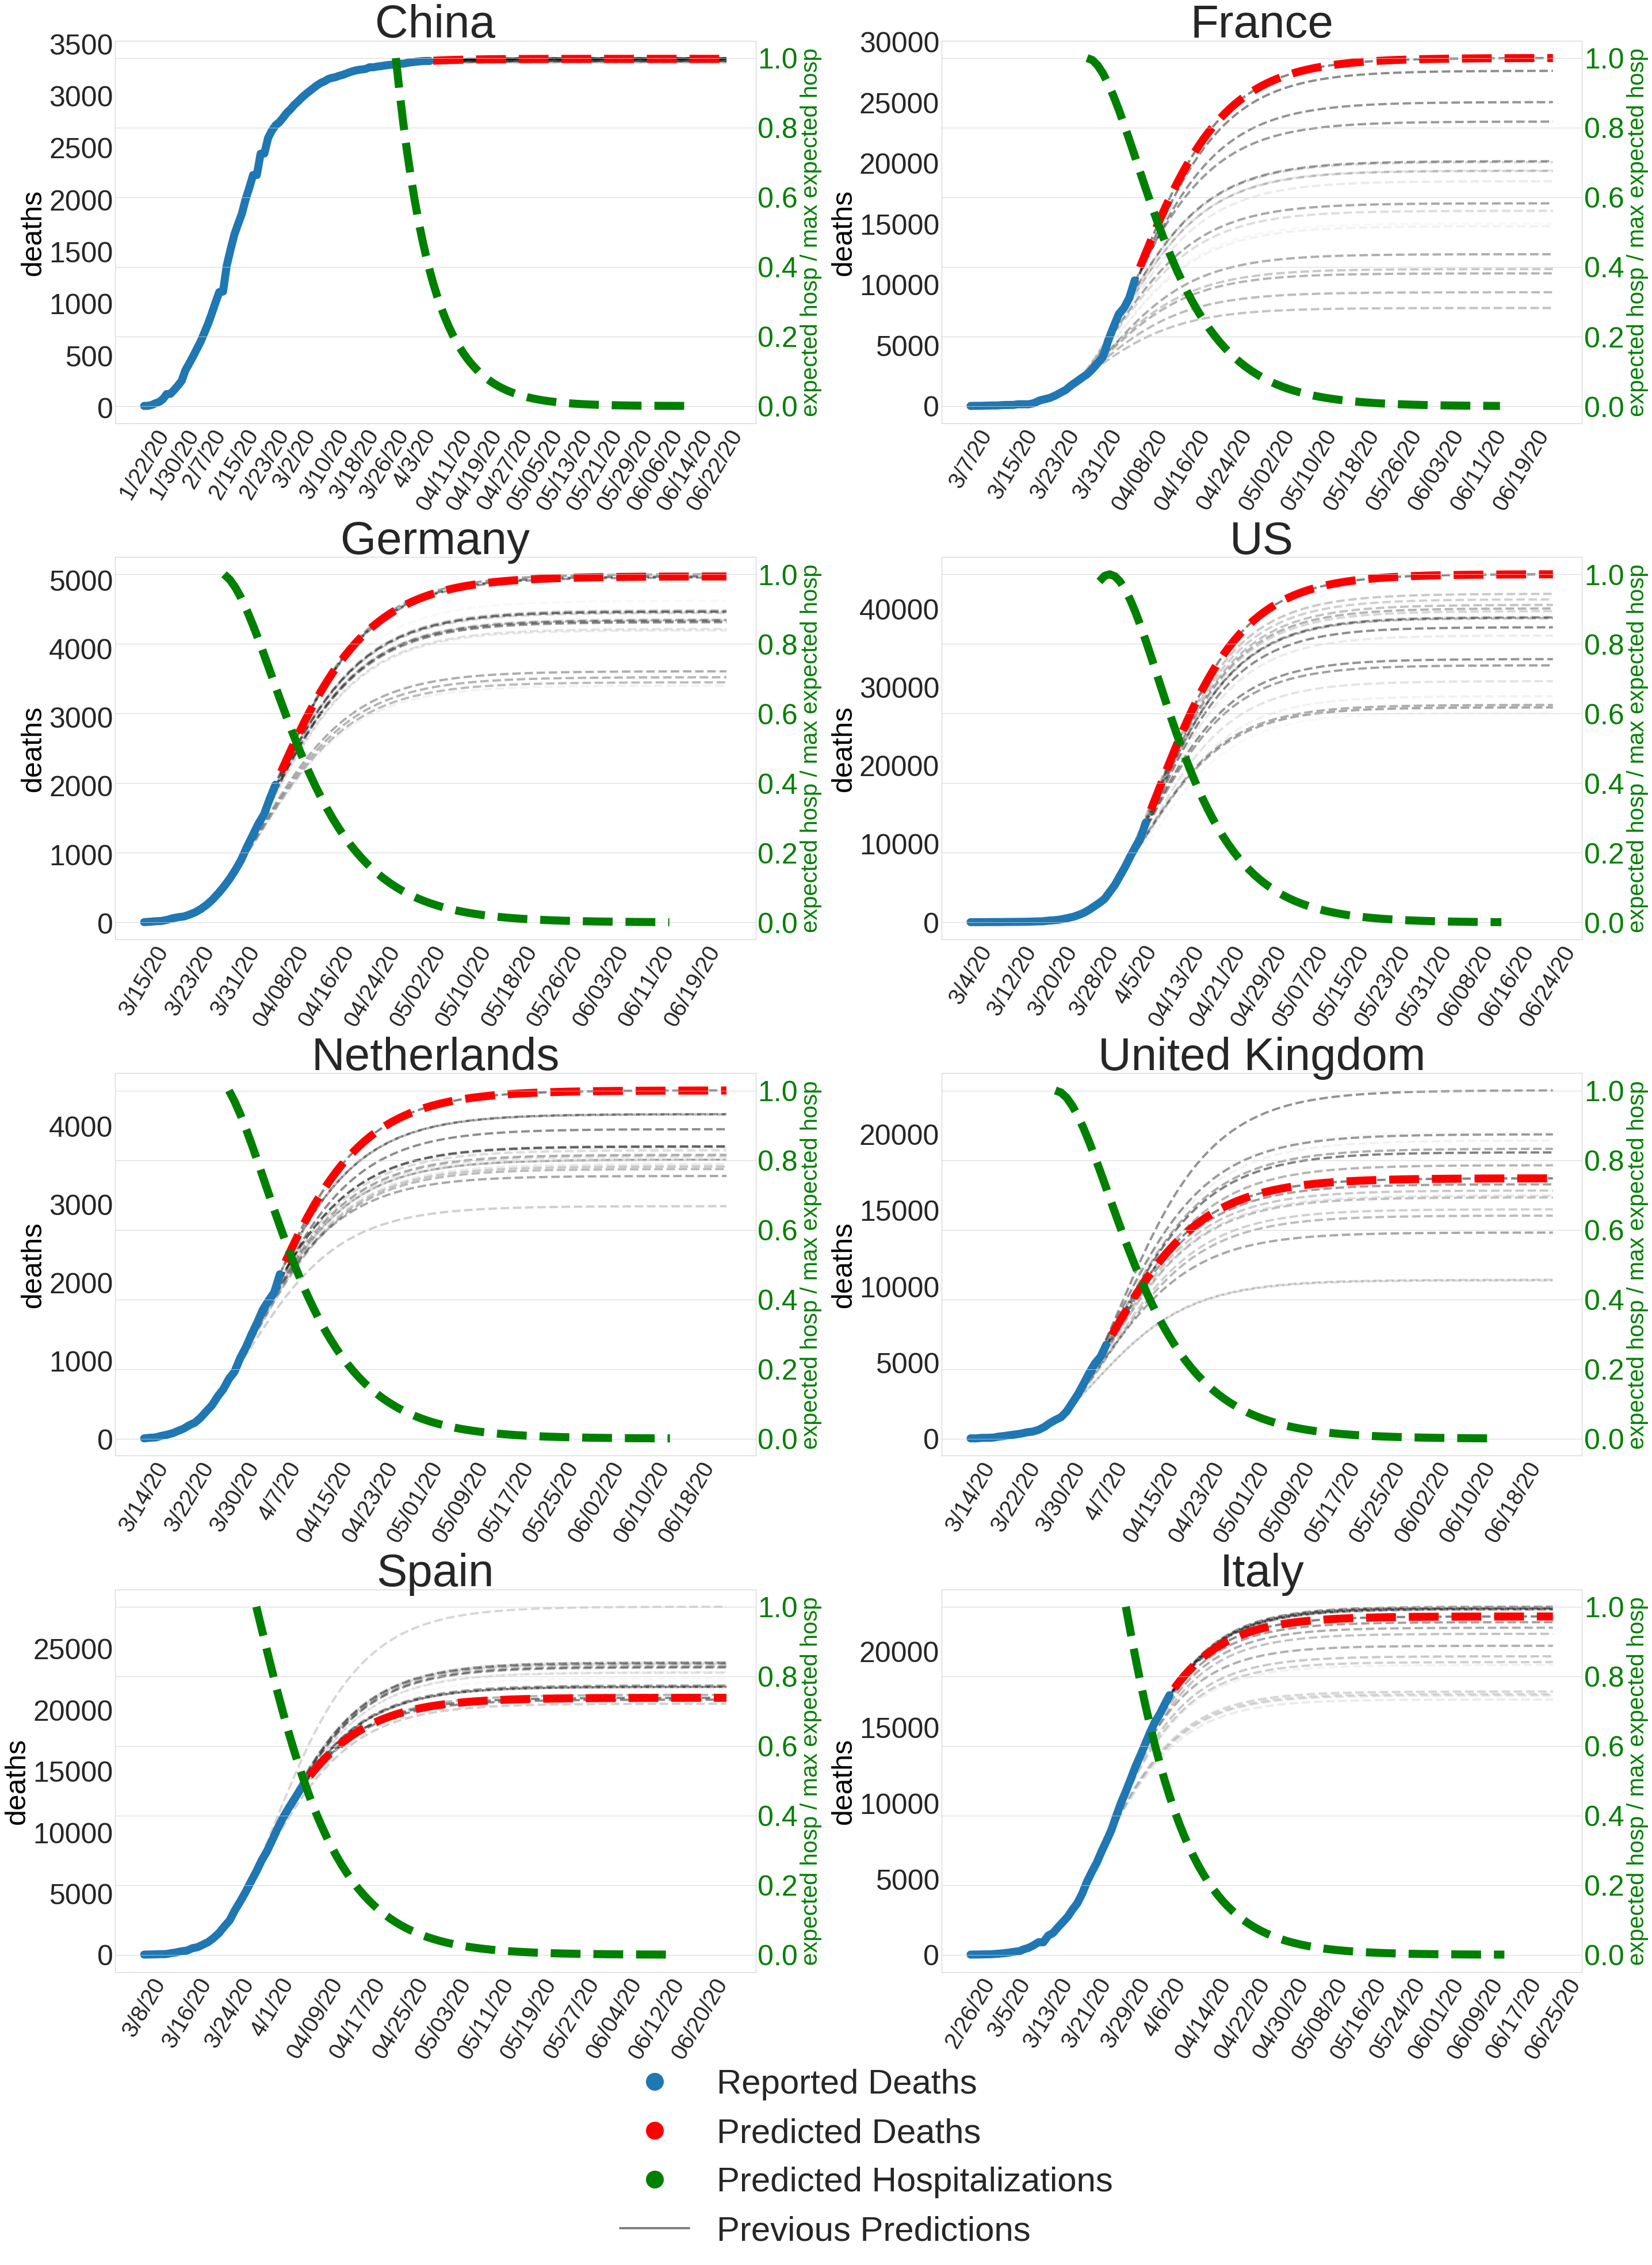

In [57]:
plt.figure(figsize=(40,50))

ax1 = plt.subplot(4,2,1)
plotPred("China", ax1)

ax1 = plt.subplot(4,2,2)
plotPred("France", ax1)

ax1 = plt.subplot(4,2,3)
plotPred("Germany", ax1)

ax1 = plt.subplot(4,2,4)
plotPred("US", ax1)

ax1 = plt.subplot(4,2,5)
plotPred("Netherlands", ax1)

ax1 = plt.subplot(4,2,6)
plotPred("United Kingdom", ax1)

ax1 = plt.subplot(4,2,7)
plotPred("Spain", ax1)

ax1 = plt.subplot(4,2,8)
plotPred("Italy", ax1)

plt.tight_layout(w_pad=1.5)

legend_elements = [Line2D([0], [0], marker='o', linewidth=0, label='Reported Deaths', markersize=30),
                   Line2D([0], [0], marker='o', linewidth=0, color="r", label='Predicted Deaths', markersize=30),
                   Line2D([0], [0], marker='o', linewidth=0, color="g", label='Predicted Hospitalizations', markersize=30),
                   Line2D([0], [0], linewidth=4, color="grey", label='Previous Predictions')]

plt.legend(handles=legend_elements, fancybox = True, fontsize=60, bbox_to_anchor=(-0.55, -0.8), loc='lower left', ncol=1)


In [48]:
for country in ["United Kingdom","Netherlands","Spain","Germany","US","China","France","Italy"]:
    printStat(country)

United Kingdom
Current Confirmed Cases: 55949
Current Confirmed Deaths: 6171
4/2/20    34173
4/3/20    38689
4/4/20    42477
4/5/20    48436
4/6/20    52279
4/7/20    55949
dtype: int64
Current Confirmed Cases: 55949
Current Confirmed Deaths: 6171
Vunerablility Factor:  1.238
Total Deaths:  17094
Current Predicted Cases:  677240
Total Predicted Cases:  743006
Growth Rate:  1.14596
Days per Doubling:  5.08756
------------------------------------
Netherlands
Current Confirmed Cases: 19709
Current Confirmed Deaths: 2108
4/2/20    14788
4/3/20    15821
4/4/20    16727
4/5/20    17953
4/6/20    18926
4/7/20    19709
dtype: int64
Current Confirmed Cases: 19709
Current Confirmed Deaths: 2108
Vunerablility Factor:  1.2503
Total Deaths:  4455
Current Predicted Cases:  179215
Total Predicted Cases:  191758
Growth Rate:  1.12487
Days per Doubling:  5.89088
------------------------------------
Spain
Current Confirmed Cases: 141942
Current Confirmed Deaths: 14045
4/2/20    112065
4/3/20    119199
4

In [49]:
def plotCaseCountry(country, ax1):
    ma = np.where(cases['Country/Region'] == country)[0]
    c_count = cases.iloc[ma, 4:].sum(axis=0)
    d_count = deaths.iloc[ma, 4:].sum(axis=0)
    
    sig_cases = np.where(c_count > 300)[0]
    
    res1, = plt.plot(c_count[sig_cases], 'ro-', linewidth=14, label="reported cases")
    plt.xticks(rotation=60, fontsize=32)
    plt.yticks(fontsize=32)
    
    ax2 = ax1.twinx()
    res3, = ax2.plot(d_count[sig_cases], 'gs-', linewidth=14, label="deaths")

    for label in ax1.xaxis.get_ticklabels()[::1]:
        label.set_visible(False)

    for label in ax1.xaxis.get_ticklabels()[::6]:
        label.set_visible(True)

    plt.yticks(fontsize=32)
    plt.title(country, fontsize=60)
    ax1.set_ylabel('confirmed cases', color="black", fontsize=45)
    color = 'green'
    ax2.set_ylabel('deaths', color=color, fontsize=45)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(handles=[res1, res3], fontsize=40)


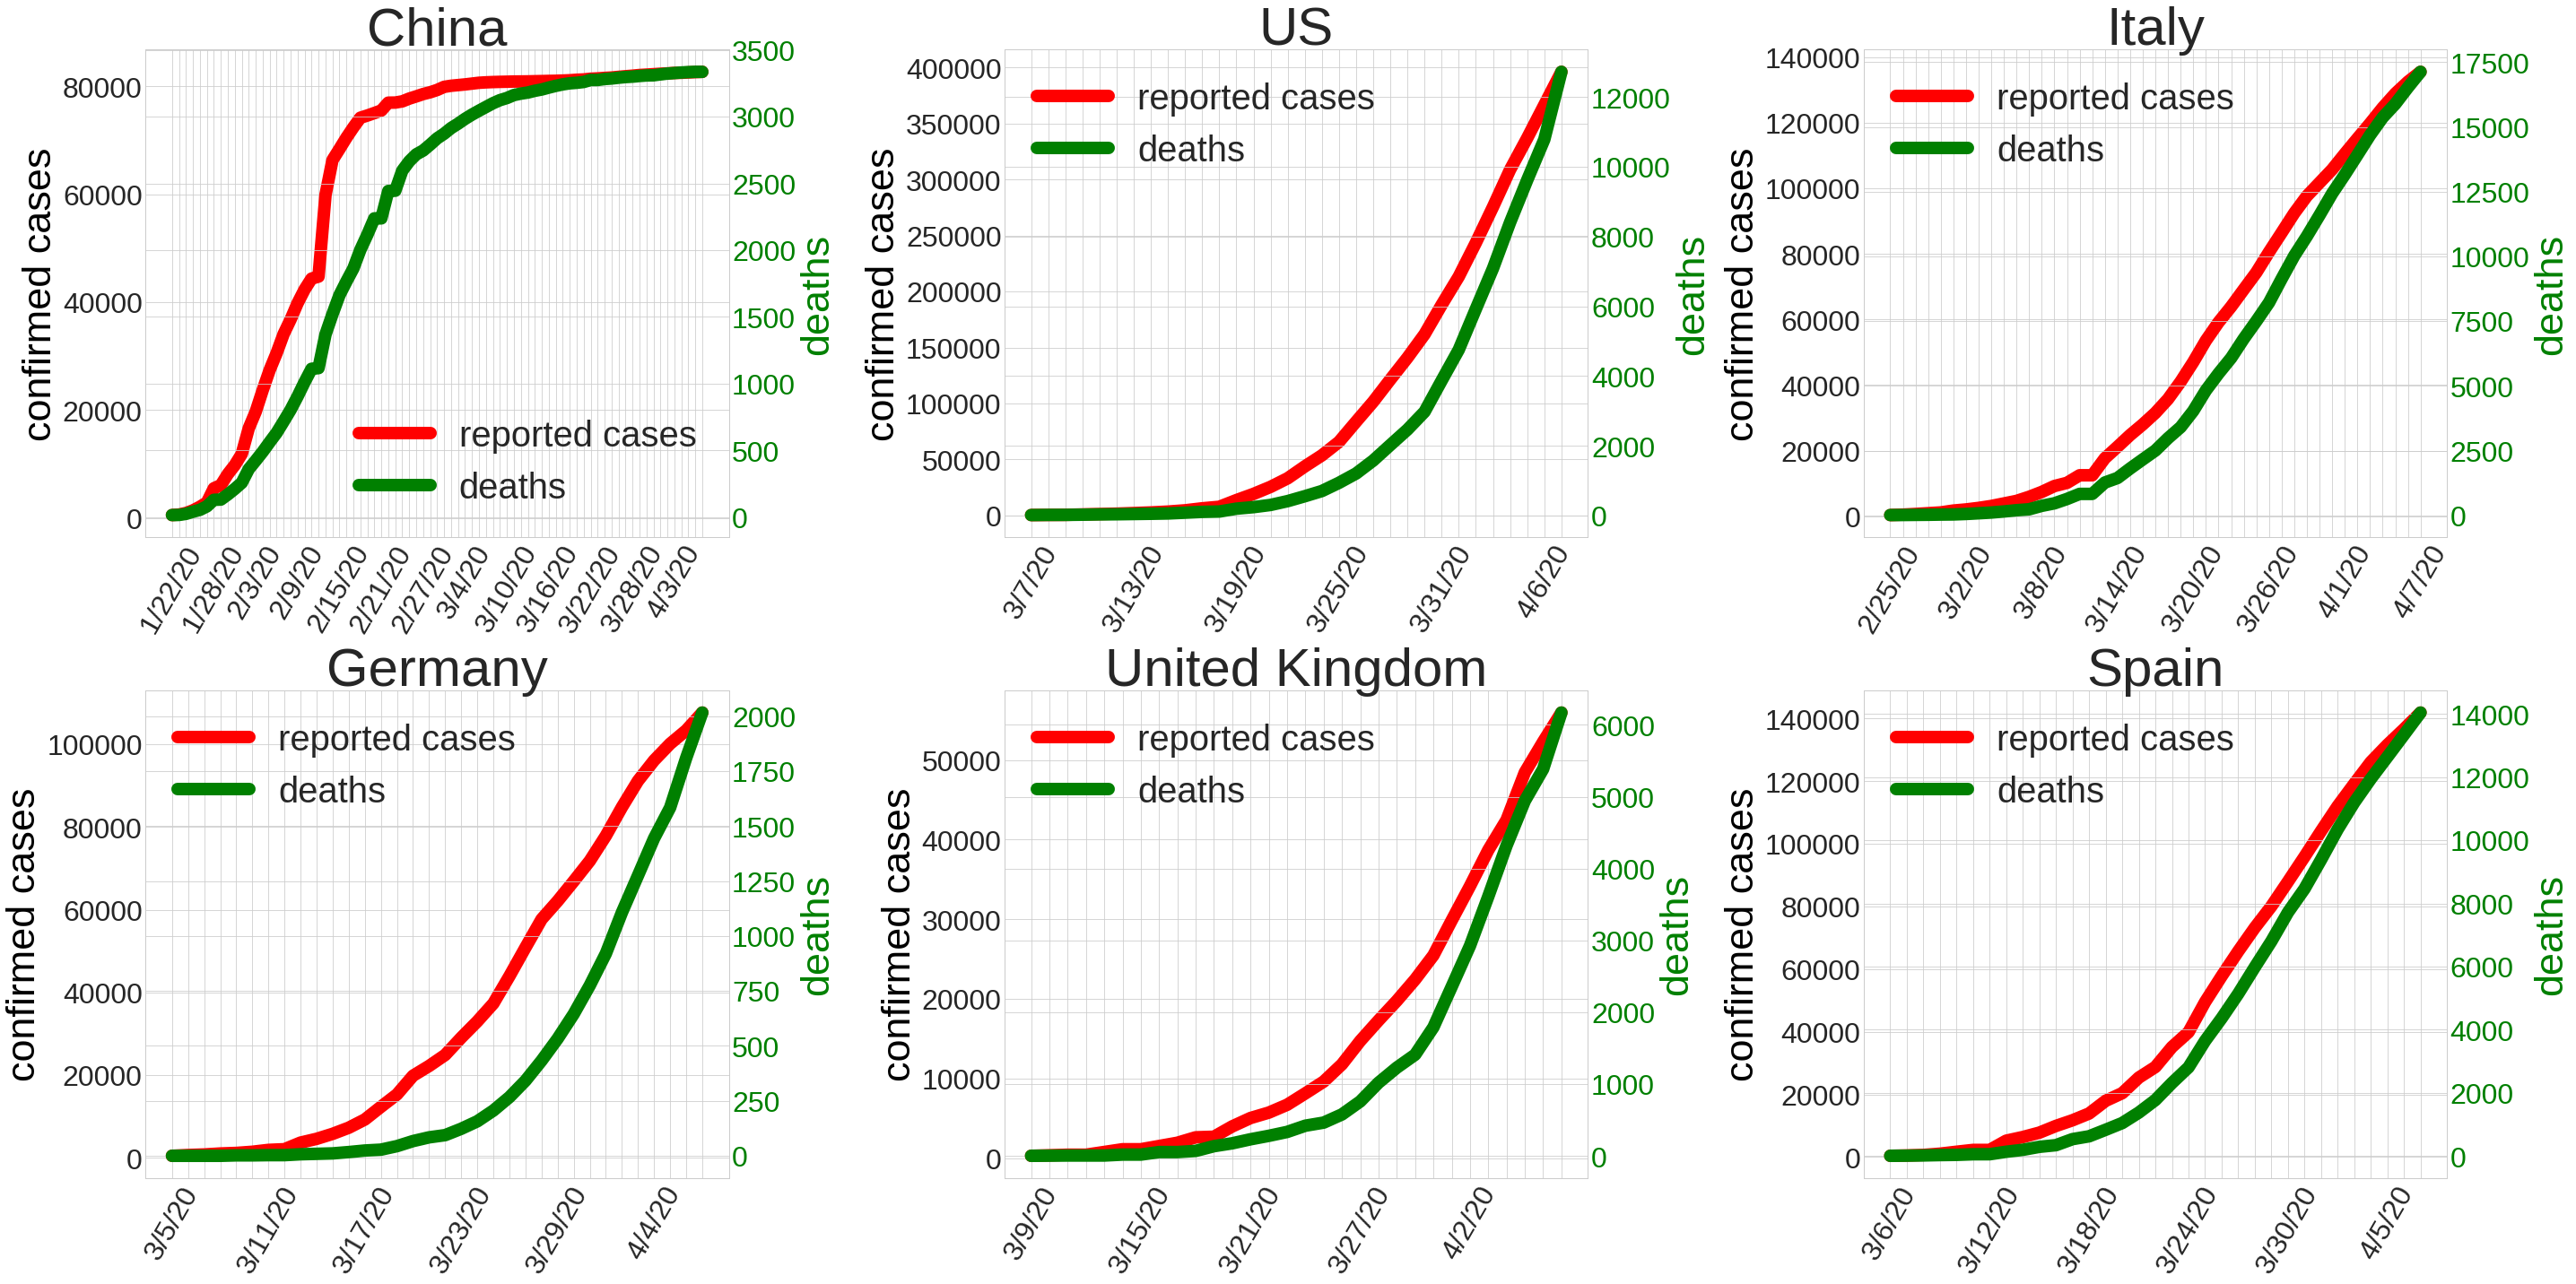

In [50]:
plt.figure(figsize=(40,20))

ax1 = plt.subplot(2,3,1)
plotCaseCountry("China", ax1)

ax1 = plt.subplot(2,3,2)
plotCaseCountry("US", ax1)

ax1 = plt.subplot(2,3,3)
plotCaseCountry("Italy", ax1)

ax1 = plt.subplot(2,3,4)
plotCaseCountry("Germany", ax1)

ax1 = plt.subplot(2,3,5)
plotCaseCountry("United Kingdom", ax1)

ax1 = plt.subplot(2,3,6)
plotCaseCountry("Spain", ax1)

plt.tight_layout(w_pad=1.5)
